# Hashing Vectorizer example
In this notebook, we'll experiment with HashingVectorizer by making a classifier that predicts whether a text chunk comes from the English Wikipedia articles ["Anarchism"](https://en.wikipedia.org/wiki/Anarchism) or ["Anachronism"](https://en.wikipedia.org/wiki/Anachronism).

## Preamble
First, let's import everything that we'll need.

In [1]:
import random

import mwapi
import mwparserfromhell as mwparser
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import HashingVectorizer

## Get the text from the API

In [2]:
session = mwapi.Session("https://en.wikipedia.org", 
                        user_agent="Hashing vectorizer example <aaron.halfaker@gmail.com>")

doc = session.get(action="query", prop="revisions", titles=["Anarchism", "Anachronism"], rvprop=['content'])

anarchism_text = doc['query']['pages']['12']['revisions'][0]['*']
anarchonism_text = doc['query']['pages']['60731']['revisions'][0]['*']

## Build up a set of observations

In [3]:
observations = []
for text_chunk in mwparser.parse(anarchism_text).filter_text():
    text = text_chunk.value
    if len(text) > 25:
        observations.append((text, "anarchism"))
for text_chunk in mwparser.parse(anarchonism_text).filter_text():
    text = text_chunk.value
    if len(text) > 25:
        observations.append((text, "anachronism"))

print("anarchism paragraphs:", sum(1 for _, label in observations if label == "anarchism"))
print("anachronism paragraphs:", sum(1 for _, label in observations if label == "anachronism"))

anarchism paragraphs: 1440
anachronism paragraphs: 116


## Split into train/test

In [4]:
random.shuffle(observations)
train_set = observations[:int(len(observations)*0.8)]
test_set = observations[int(len(observations)*0.8):]
len(train_set), len(test_set)

(1244, 312)

## HashingVectorizer and prediction model
We'll use a GradientBoosting model because it ought to work pretty well

In [13]:
hv = HashingVectorizer(n_features=2**16)
gbc = GradientBoostingClassifier()

## Train the classifier
We'll set the "sample weight" to be proportionally stronger for "Anachronism" because we don't have as many observations.

In [14]:
# Training
texts, labels_y = zip(*train_set)
features_X = hv.transform(texts)
gbc.fit(features_X, labels_y, 
        sample_weight=[119/(119+1433) if l == "anarchism" else 1433/(119+1433) for l in labels_y])

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

## Test the classifier
This score() method generates a simple accuracy measure.  This result suggest that we can predict ~86% of the test set correctly.

In [15]:
# Testing
texts, labels_y = zip(*test_set)
features_X = hv.transform(texts)
gbc.score(features_X.todense(), labels_y)

0.95192307692307687

Statistics are great, but let's look at some example predictions.  This loop generates predictions 

In [16]:
for text, label in test_set[:10]:
    features_X = hv.transform([text])
    print("text:", repr(text[:50] + "..."), "\n",
          "\tactual:", label, "\n",
          "\tprediction:", dict(zip(gbc.classes_, 
                                    [int(v*100) for v in gbc.predict_proba(features_X.todense())[0]])))
    

text: ' Tolstoy established a conceptual difference betwe...' 
 	actual: anarchism 
 	prediction: {'anachronism': 28, 'anarchism': 71}
text: 'http://newleftreview.org/II/28/benedict-anderson-i...' 
 	actual: anarchism 
 	prediction: {'anachronism': 63, 'anarchism': 36}
text: '– an online collection of news and information abo...' 
 	actual: anarchism 
 	prediction: {'anachronism': 8, 'anarchism': 91}
text: 'Communist Party of Spain (main)...' 
 	actual: anarchism 
 	prediction: {'anachronism': 28, 'anarchism': 71}
text: 'thumb|left|May day demonstration of Spanish ...' 
 	actual: anarchism 
 	prediction: {'anachronism': 28, 'anarchism': 71}
text: 'Confederación Nacional del Trabajo...' 
 	actual: anarchism 
 	prediction: {'anachronism': 28, 'anarchism': 71}
text: 'http://www.theanarchistlibrary.org/HTML/Murray_Boo...' 
 	actual: anarchism 
 	prediction: {'anachronism': 10, 'anarchism': 89}
text: '"T.A.Z.: The Temporary Autonomous Zone, Ontologica...' 
 	actual: anarchism 
 	prediction:

## Feature selection
Let's build a histogram of the feature importance measurments.

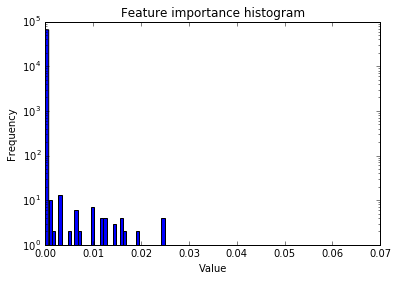

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(gbc.feature_importances_, bins=100, log=True)
#plt.semilogy()
plt.title("Feature importance histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")